In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sksurv
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sksurv.metrics import integrated_brier_score

In [214]:
##upload dataset ready for prediction models
#Cohort 1: clinical+GWAS+Case1
X_train_integrate_1_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_1_imp.csv')
X_test_integrate_1_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_1_imp.csv')
y_train_integrate_1= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_1.csv')
y_test_integrate_1= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_1.csv')
#Cohort 1: clinical+Case1
X_train_integrate_1cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_1cli_imp.csv')
X_test_integrate_1cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_1cli_imp.csv')
y_train_integrate_1cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_1cli.csv')
y_test_integrate_1cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_1cli.csv')
#Cohort 1: clinical+GWAS+Case2
X_train_integrate_2_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_2_imp.csv')
X_test_integrate_2_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_2_imp.csv')
y_train_integrate_2= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_2.csv')
y_test_integrate_2= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_2.csv')
#Cohort 1: clinical+Case2
X_train_integrate_2cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_2cli_imp.csv')
X_test_integrate_2cli_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_2cli_imp.csv')
y_train_integrate_2cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_2cli.csv')
y_test_integrate_2cli= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_2cli.csv')
#Cohort 2: clinical+GWAS+mRNA
X_train_overall_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_imp.csv')
X_test_overall_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_imp.csv')
y_train_overall= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall.csv')
y_test_overall= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall.csv')
#Cohort 2: clinical+mRNA
X_train_overall_mrna_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_mrna_imp.csv') #1584x250
X_test_overall_mrna_imp= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_mrna_imp.csv') #396x250
y_train_overall_mrna= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall_mrna.csv')#1584x3
y_test_overall_mrna= pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall_mrna.csv') #396x3
#Cohort 1: clinical+GWAS
X_train_integrate_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_integrate_gwas_imp.csv')
X_test_integrate_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_integrate_gwas_imp.csv')
y_train_integrate_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_integrate_gwas.csv')
y_test_integrate_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_integrate_gwas.csv')
#Cohort 2: clinical+GWAS
X_train_overall_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_train_overall_gwas_imp.csv')
X_test_overall_gwas_imp=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/X_test_overall_gwas_imp.csv')
y_train_overall_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_train_overall_gwas.csv')
y_test_overall_gwas=pd.read_csv('/Users/mac1/Desktop/Test_Train_15_85/y_test_overall_gwas.csv')

In [208]:
##elastic net without cv
def elasticnet_cox_sweep_l1_plot(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.DataFrame,
    y_test: pd.DataFrame,
    test_size: float = 0.2,
    l1_list=(0.1, 0.2, 0.5),
    random_state: int = 123,
    alpha_min_ratio: float = 1e-4,
    n_alphas: int = 100,
    n_time_grid: int = 100,
    coef_tol: float = 1e-12,
    feature_set: str = "full",
    title: str | None = None,
):
    """
    Elastic-net Cox sweep over l1_ratio with:
      - validation C-index
      - test C-index
      - test IBS

    If Xtr_used / Xte_used are provided, they are used directly.
    Otherwise defaults to Xtr_full / Xte_full constructed internally.
    """

    # ---------------- copies ----------------
    X_train = X_train.copy()
    X_test  = X_test.copy()
    y_train = y_train.copy()
    y_test  = y_test.copy()

    # ---------------- OS_STATUS → numeric ----------------
    for df in (y_train, y_test):
        if "OS_STATUS_NUM" not in df.columns:
            df["OS_STATUS_NUM"] = (
                df["OS_STATUS"].astype(str)
                .str.split(":", expand=True)[0]
                .astype(int)
            )

    # ---------------- survival objects ----------------
    ytr = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_train["OS_STATUS_NUM"], y_train["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )
    yte = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_test["OS_STATUS_NUM"], y_test["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )

    # ---------------- build default full feature set ----------------
    cont_cols = list(range(4, 9))
    cat_cols  = list(range(9, 27))
    gen_cols  = list(range(27, X_train.shape[1]))

    Xtr_cont = X_train.iloc[:, cont_cols]
    Xte_cont = X_test.iloc[:, cont_cols]

    Xtr_cat = pd.get_dummies(X_train.iloc[:, cat_cols], drop_first=True)
    Xte_cat = pd.get_dummies(X_test.iloc[:,  cat_cols], drop_first=True)
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

    Xtr_gen = X_train.iloc[:, gen_cols]
    Xte_gen = X_test.iloc[:, gen_cols]

    Xtr_cli = pd.concat([Xtr_cont, Xtr_cat], axis=1)
    Xte_cli = pd.concat([Xte_cont, Xte_cat], axis=1)
    Xtr_full = pd.concat([Xtr_cont, Xtr_cat, Xtr_gen], axis=1)
    Xte_full = pd.concat([Xte_cont, Xte_cat, Xte_gen], axis=1)

    # ---------------- choose feature matrix ----------------
    fs = feature_set.lower()
    if fs in ("full", "all"):
        Xtr, Xte = Xtr_full, Xte_full
    elif fs in ("cli", "clinical"):
        Xtr, Xte = Xtr_cli, Xte_cli
    elif fs in ("gen", "genetic", "omics"):
        Xtr, Xte = Xtr_gen, Xte_gen

    # ---------------- validation split ----------------
    idx = np.arange(Xtr.shape[0])
    idx_tr, idx_val = train_test_split(idx, test_size=test_size, random_state=random_state)
    ytr_in, ytr_val = ytr[idx_tr], ytr[idx_val]

    # ---------------- IBS time grid ----------------
    t_min = max(ytr["time"].min(), yte["time"].min())
    t_max = min(ytr["time"].max(), yte["time"].max())
    eps = 1e-8
    times = np.linspace(t_min, t_max - eps, n_time_grid)

    rows = []
    best_overall = {"val_cindex": -np.inf}

    # ================= sweep l1 =================
    for l1 in l1_list:
        path_model = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alpha_min_ratio=alpha_min_ratio,
            n_alphas=n_alphas
        )
        path_model.fit(Xtr.iloc[idx_tr].to_numpy(), ytr_in)

        best_alpha, best_val_ci = None, -np.inf
        X_val_np = Xtr.iloc[idx_val].to_numpy()

        for a in path_model.alphas_:
            risk_val = path_model.predict(X_val_np, alpha=float(a))
            ci = concordance_index_censored(
                ytr_val["event"], ytr_val["time"], risk_val
            )[0]
            if ci > best_val_ci:
                best_val_ci, best_alpha = float(ci), float(a)

        final_model = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alphas=[best_alpha],
            fit_baseline_model=True
        )
        final_model.fit(Xtr.to_numpy(), ytr)

        # test metrics
        risk_te = final_model.predict(Xte.to_numpy())
        test_ci = concordance_index_censored(
            yte["event"], yte["time"], risk_te
        )[0]

        surv_fns = final_model.predict_survival_function(Xte.to_numpy())
        surv_te  = np.vstack([fn(times) for fn in surv_fns])
        test_ibs = integrated_brier_score(ytr, yte, surv_te, times)

        n_selected = int(np.sum(np.abs(final_model.coef_.ravel()) > coef_tol))

        rows.append({
            "l1_ratio": l1,
            "val_cindex": best_val_ci,
            "test_cindex": float(test_ci),
            "test_ibs": float(test_ibs),
            "best_alpha": best_alpha,
            "n_selected": n_selected,
        })

        if best_val_ci > best_overall["val_cindex"]:
            best_overall = {
                "val_cindex": best_val_ci,
                "l1_ratio": l1,
                "alpha": best_alpha,
                "model": final_model,
            }

    results_df = pd.DataFrame(rows).sort_values("l1_ratio").reset_index(drop=True)
    best_idx = results_df["val_cindex"].idxmax()

    # ================= plotting =================
    fig, ax1 = plt.subplots(figsize=(7.5, 4.5))

    x = results_df["l1_ratio"].values
    ax1.plot(x, results_df["val_cindex"], marker="o", label="Validation C-index")
    ax1.plot(x, results_df["test_cindex"], marker="o", label="Test C-index")
    ax1.set_xlabel("l1_ratio")
    ax1.set_ylabel("C-index")
    ax1.set_ylim(0.62, 0.70)
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.annotate(
        "Best val",
        xy=(results_df.loc[best_idx, "l1_ratio"],
            results_df.loc[best_idx, "val_cindex"]),
        xytext=(5, 5),
        textcoords="offset points"
    )

    ax2 = ax1.twinx()
    ax2.plot(x, results_df["test_ibs"], marker="o", label="Test IBS")
    ax2.set_ylabel("IBS")

    if title is not None:
        ax1.set_title(title)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    fig.tight_layout()
    return results_df, best_overall, fig, (ax1, ax2),final_model


In [227]:
##elastic net with cv
def elasticnet_cox_cv(
        X_train: pd.DataFrame,
        X_test: pd.DataFrame,
        y_train: pd.DataFrame,
        y_test: pd.DataFrame,
        test_size: float = 0.2,  # kept for backward compatibility, no longer used if cv_fold>=2
        l1_list=(0.1, 0.2, 0.5),
        random_state: int = 123,
        alpha_min_ratio: float = 1e-4,
        n_alphas: int = 100,
        n_time_grid: int = 100,
        coef_tol: float = 1e-12,
        feature_set: str = "full",
        title: str | None = None,
        cv_fold: int = 5,  # <-- NEW
):
    """
    Elastic-net Cox sweep over l1_ratio with:
      - CV C-index (replaces fixed 20% validation split)
      - test C-index
      - test IBS
    """

    # ---------------- copies ----------------
    X_train = X_train.copy()
    X_test = X_test.copy()
    y_train = y_train.copy()
    y_test = y_test.copy()

    # ---------------- OS_STATUS → numeric ----------------
    for df in (y_train, y_test):
        if "OS_STATUS_NUM" not in df.columns:
            df["OS_STATUS_NUM"] = (
                df["OS_STATUS"].astype(str)
                .str.split(":", expand=True)[0]
                .astype(int)
            )

    # ---------------- survival objects ----------------
    ytr = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_train["OS_STATUS_NUM"], y_train["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )
    yte = np.array(
        [(bool(e), float(t)) for e, t in zip(
            y_test["OS_STATUS_NUM"], y_test["OS_MONTHS"]
        )],
        dtype=[("event", "?"), ("time", "<f8")]
    )

    # ---------------- build default full feature set ----------------
    cont_cols = list(range(4, 9))
    cat_cols = list(range(9, 27))
    gen_cols = list(range(27, X_train.shape[1]))

    Xtr_cont = X_train.iloc[:, cont_cols]
    Xte_cont = X_test.iloc[:, cont_cols]

    Xtr_cat = pd.get_dummies(X_train.iloc[:, cat_cols], drop_first=True)
    Xte_cat = pd.get_dummies(X_test.iloc[:, cat_cols], drop_first=True)
    Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0)

    Xtr_gen = X_train.iloc[:, gen_cols]
    Xte_gen = X_test.iloc[:, gen_cols]

    Xtr_cli = pd.concat([Xtr_cont, Xtr_cat], axis=1)
    Xte_cli = pd.concat([Xte_cont, Xte_cat], axis=1)
    Xtr_full = pd.concat([Xtr_cont, Xtr_cat, Xtr_gen], axis=1)
    Xte_full = pd.concat([Xte_cont, Xte_cat, Xte_gen], axis=1)

    # ---------------- choose feature matrix ----------------
    fs = feature_set.lower()
    if fs in ("full", "all"):
        Xtr, Xte = Xtr_full, Xte_full
    elif fs in ("cli", "clinical"):
        Xtr, Xte = Xtr_cli, Xte_cli
    elif fs in ("gen", "genetic", "omics"):
        Xtr, Xte = Xtr_gen, Xte_gen
    else:
        raise ValueError(f"Unknown feature_set: {feature_set}")

    # ---------------- IBS time grid ----------------
    t_min = max(ytr["time"].min(), yte["time"].min())
    t_max = min(ytr["time"].max(), yte["time"].max())
    eps = 1e-8
    times = np.linspace(t_min, t_max - eps, n_time_grid)

    # ---------------- CV splitter ----------------
    # (Use StratifiedKFold-like behavior for survival is tricky; we use KFold w/ shuffle)
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv_fold, shuffle=True, random_state=random_state)

    rows = []
    best_overall = {"cv_cindex": -np.inf}

    # ================= sweep l1 =================
    for l1 in l1_list:
        # 1) Fit once on full training to get a stable alpha grid for this l1
        path_full = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alpha_min_ratio=alpha_min_ratio,
            n_alphas=n_alphas
        )
        path_full.fit(Xtr.to_numpy(), ytr)
        alpha_grid = np.asarray(path_full.alphas_)

        # 2) CV evaluate each alpha
        fold_scores = np.zeros((cv_fold, alpha_grid.shape[0]), dtype=float)

        Xtr_np = Xtr.to_numpy()
        for f, (idx_tr, idx_val) in enumerate(kf.split(Xtr_np)):
            X_in, X_val = Xtr_np[idx_tr], Xtr_np[idx_val]
            y_in, y_val = ytr[idx_tr], ytr[idx_val]

            path_model = CoxnetSurvivalAnalysis(
                l1_ratio=float(l1),
                alphas=alpha_grid
            )
            path_model.fit(X_in, y_in)

            for j, a in enumerate(alpha_grid):
                risk_val = path_model.predict(X_val, alpha=float(a))
                ci = concordance_index_censored(
                    y_val["event"], y_val["time"], risk_val
                )[0]
                fold_scores[f, j] = float(ci)

        mean_ci = fold_scores.mean(axis=0)
        j_best = int(np.argmax(mean_ci))
        best_alpha = float(alpha_grid[j_best])
        best_cv_ci = float(mean_ci[j_best])

        # 3) Refit final model on full training with best alpha for this l1
        final_model = CoxnetSurvivalAnalysis(
            l1_ratio=float(l1),
            alphas=[best_alpha],
            fit_baseline_model=True
        )
        final_model.fit(Xtr_np, ytr)

        # test metrics
        risk_te = final_model.predict(Xte.to_numpy())
        test_ci = concordance_index_censored(
            yte["event"], yte["time"], risk_te
        )[0]

        surv_fns = final_model.predict_survival_function(Xte.to_numpy())
        surv_te = np.vstack([fn(times) for fn in surv_fns])
        test_ibs = integrated_brier_score(ytr, yte, surv_te, times)

        n_selected = int(np.sum(np.abs(final_model.coef_.ravel()) > coef_tol))

        rows.append({
            "l1_ratio": l1,
            "cv_cindex": best_cv_ci,  # <-- renamed from val_cindex
            "test_cindex": float(test_ci),
            "test_ibs": float(test_ibs),
            "best_alpha": best_alpha,
            "n_selected": n_selected,
        })

        if best_cv_ci > best_overall["cv_cindex"]:
            best_overall = {
                "cv_cindex": best_cv_ci,
                "l1_ratio": float(l1),
                "alpha": best_alpha,
                "model": final_model,
            }

    results_df = pd.DataFrame(rows).sort_values("l1_ratio").reset_index(drop=True)
    best_idx = results_df["cv_cindex"].idxmax()

    # ================= plotting =================
    fig, ax1 = plt.subplots(figsize=(7.5, 4.5))

    x = results_df["l1_ratio"].values
    ax1.plot(x, results_df["cv_cindex"], marker="o", label=f"{cv_fold}-fold CV C-index")
    ax1.plot(x, results_df["test_cindex"], marker="o", label="Test C-index")
    ax1.set_xlabel("l1_ratio")
    ax1.set_ylabel("C-index")
    ax1.set_ylim(0.62, 0.70)
    ax1.grid(True, linestyle="--", alpha=0.5)

    ax1.annotate(
        "Best CV",
        xy=(results_df.loc[best_idx, "l1_ratio"],
            results_df.loc[best_idx, "cv_cindex"]),
        xytext=(5, 5),
        textcoords="offset points"
    )

    ax2 = ax1.twinx()
    ax2.plot(x, results_df["test_ibs"], marker="o", label="Test IBS")
    ax2.set_ylabel("IBS")

    if title is not None:
        ax1.set_title(title)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    fig.tight_layout()
    return results_df, best_overall, fig, (ax1, ax2), final_model


   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.693321     0.693799  0.150172    0.256014         119
1      0.10    0.692313     0.693198  0.151105    0.169218          96
2      0.15    0.691920     0.691564  0.151447    0.112812          94
3      0.20    0.692043     0.691163  0.151700    0.092858          87
4      0.25    0.691773     0.691597  0.151851    0.074287          87
{'val_cindex': 0.6933212064600182, 'l1_ratio': 0.05, 'alpha': 0.25601442916868694, 'model': CoxnetSurvivalAnalysis(alphas=[0.25601442916868694], fit_baseline_model=True,
                       l1_ratio=0.05)}


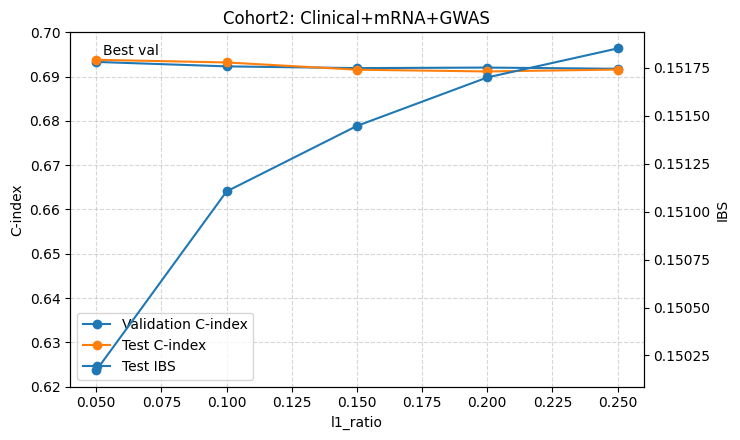

In [200]:
results_df_overall, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_overall_imp,
    X_test=X_test_overall_imp,
    y_train=y_train_overall,
    y_test=y_test_overall,
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort2: Clinical+GWAS+mrna"
)
print(results_df_overall)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.681178     0.690496  0.157642    0.017240          43
1      0.10    0.681203     0.691030  0.157273    0.015064          41
2      0.15    0.681301     0.690830  0.157093    0.013276          36
3      0.20    0.681178     0.691263  0.157135    0.010928          34
4      0.25    0.681350     0.690096  0.156376    0.013920          30
{'val_cindex': 0.681350015977975, 'l1_ratio': 0.25, 'alpha': 0.013919956342159558, 'model': CoxnetSurvivalAnalysis(alphas=[0.013919956342159558], fit_baseline_model=True,
                       l1_ratio=0.25)}


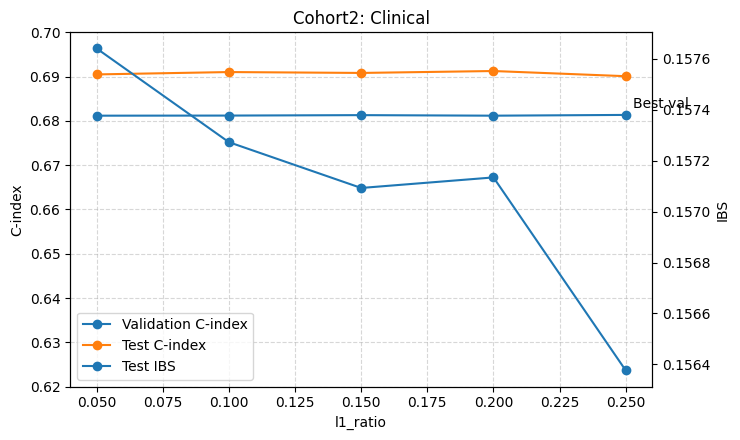

In [171]:
results_df_overall_cli, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_overall_imp,
    X_test=X_test_overall_imp,
    y_train=y_train_overall,
    y_test=y_test_overall,
    feature_set='cli',
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort2: Clinical only"
)
print(results_df_overall_cli)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.670927     0.672649  0.155952    0.338436          62
1      0.10    0.671198     0.668913  0.156224    0.223696          46
2      0.15    0.670977     0.667745  0.156515    0.149131          41
3      0.20    0.671345     0.667178  0.156732    0.111848          41
4      0.25    0.671296     0.666945  0.155237    0.129818          27
{'val_cindex': 0.671345345492982, 'l1_ratio': 0.2, 'alpha': 0.11184812144600899, 'model': CoxnetSurvivalAnalysis(alphas=[0.11184812144600899], fit_baseline_model=True,
                       l1_ratio=0.2)}


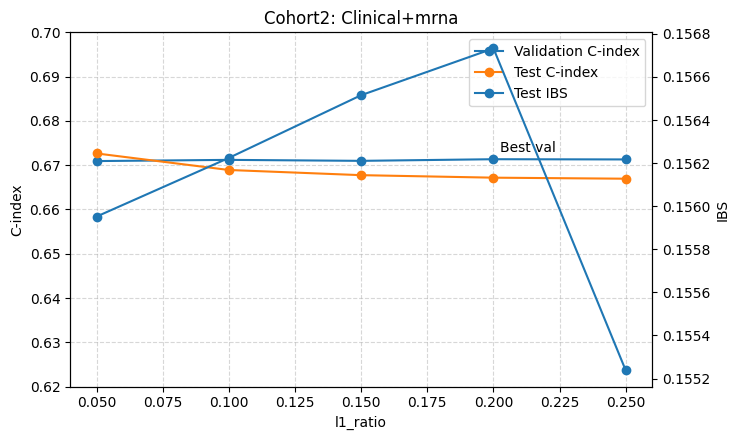

In [215]:
results_df_overall_mrna, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_overall_mrna_imp,
    X_test=X_test_overall_mrna_imp,
    y_train=y_train_overall_mrna,
    y_test=y_test_overall_mrna,
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort2: Clinical+mrna"
)
print(results_df_overall_mrna)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.686349     0.676889  0.159468    0.006314          43
1      0.10    0.686617     0.677191  0.159277    0.006055          41
2      0.15    0.686884     0.676405  0.160050    0.002535          42
3      0.20    0.686884     0.676465  0.160042    0.002290          42
4      0.25    0.686884     0.677856  0.159288    0.003857          35
{'val_cindex': 0.6868843683083512, 'l1_ratio': 0.15, 'alpha': 0.0025352265542563607, 'model': CoxnetSurvivalAnalysis(alphas=[0.0025352265542563607], fit_baseline_model=True,
                       l1_ratio=0.15)}


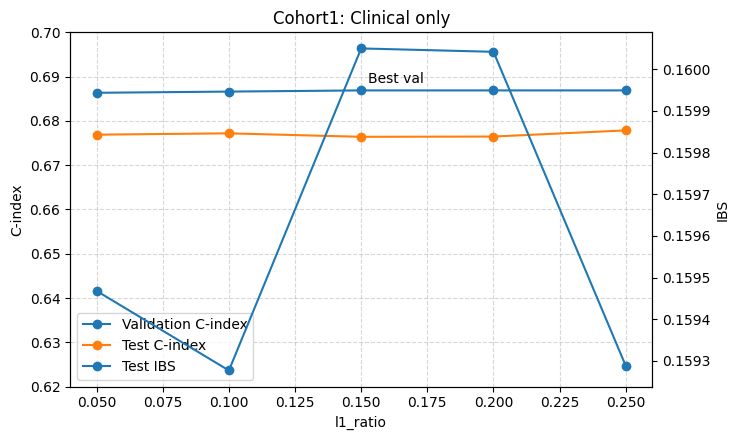

In [213]:
results_df_integrate1, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_1_imp,
    X_test=X_test_integrate_1_imp,
    y_train=y_train_integrate_1,
    y_test=y_test_integrate_1,
    feature_set='cli',
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort1: Clinical only"
)
print(results_df_integrate1)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.691006     0.682393  0.153485    0.314268         195
1      0.10    0.687955     0.680276  0.153639    0.189268         158
2      0.15    0.688597     0.681667  0.153716    0.151983         121
3      0.20    0.686831     0.679610  0.154213    0.103861         137
4      0.25    0.686670     0.680518  0.154010    0.091190         116
{'val_cindex': 0.6910064239828694, 'l1_ratio': 0.05, 'alpha': 0.31426762677866854, 'model': CoxnetSurvivalAnalysis(alphas=[0.31426762677866854], fit_baseline_model=True,
                       l1_ratio=0.05)}


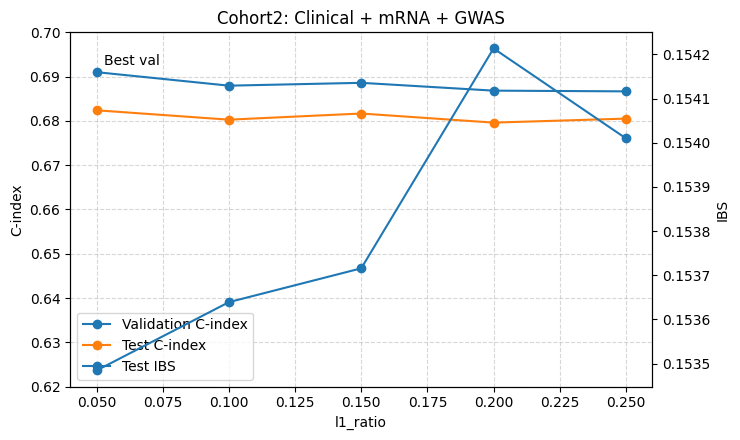

In [172]:
results_df_integrate1, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_1_imp,
    X_test=X_test_integrate_1_imp,
    y_train=y_train_integrate_1,
    y_test=y_test_integrate_1,
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort1: Clinical + case1 + GWAS"
)
print(results_df_integrate1)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.01    0.704497     0.702776  0.145690    0.268283         206
1      0.05    0.705139     0.700357  0.146836    0.123954         170
2      0.10    0.705942     0.699571  0.147472    0.081930         153
3      0.15    0.704979     0.698300  0.147881    0.059945         144
4      0.20    0.705193     0.698421  0.147676    0.040965         148
5      0.25    0.705246     0.697514  0.147972    0.035967         144
{'val_cindex': 0.7059421841541755, 'l1_ratio': 0.1, 'alpha': 0.0819297005336985, 'model': CoxnetSurvivalAnalysis(alphas=[0.0819297005336985], fit_baseline_model=True,
                       l1_ratio=0.1)}


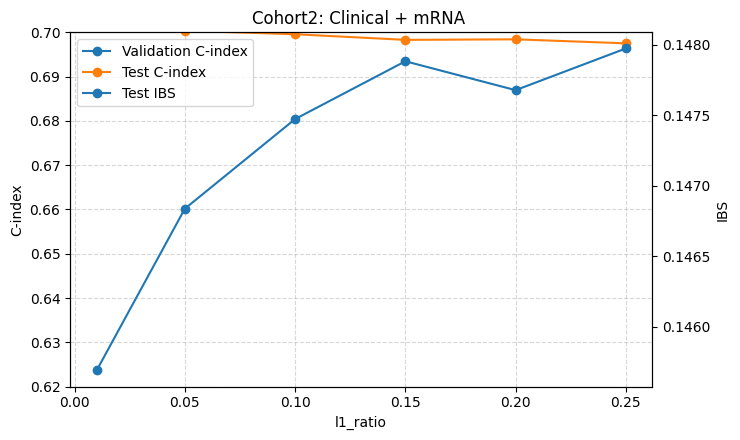

In [210]:
results_df_integrate1cli, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_1cli_imp,
    X_test=X_test_integrate_1cli_imp,
    y_train=y_train_integrate_1cli,
    y_test=y_test_integrate_1cli,
    l1_list=[0.01,0.05,0.1,0.15,0.2,0.25],
    title="Cohort1: Clinical + case1 "
)
print(results_df_integrate1cli)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.702784     0.694792  0.150909    0.260911         273
1      0.10    0.702463     0.696970  0.150373    0.207722         166
2      0.15    0.702570     0.694550  0.150844    0.138481         168
3      0.20    0.702998     0.696486  0.149870    0.125101         131
4      0.25    0.702837     0.697333  0.150003    0.100081         128
5      0.50    0.701713     0.696304  0.150372    0.050040         123
{'val_cindex': 0.7029978586723769, 'l1_ratio': 0.2, 'alpha': 0.12510073365595356, 'model': CoxnetSurvivalAnalysis(alphas=[0.12510073365595356], fit_baseline_model=True,
                       l1_ratio=0.2)}


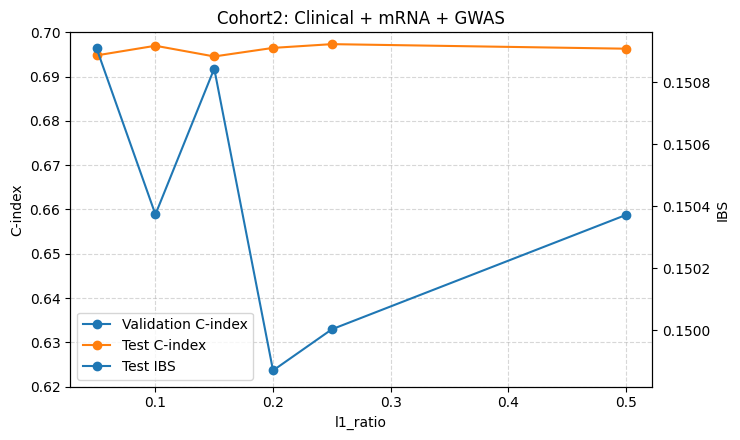

In [177]:
results_df_integrate2, best_overall, fig, axes,final_model_integrate2=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_2_imp,
    X_test=X_test_integrate_2_imp,
    y_train=y_train_integrate_2,
    y_test=y_test_integrate_2,
    l1_list=[0.05,0.1,0.15,0.2,0.25,0.5],
    title="Cohort1: Clinical + case2 + GWAS"
)
print(results_df_integrate2)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.01    0.703694     0.711305  0.145740    0.746513         244
1      0.05    0.703908     0.712514  0.146615    0.314268         149
2      0.10    0.705407     0.710700  0.147466    0.207722         116
3      0.15    0.706210     0.710700  0.147561    0.138481         107
4      0.20    0.707173     0.710276  0.147732    0.113987          98
5      0.25    0.707602     0.710276  0.147762    0.091190          98
6      0.30    0.706478     0.710821  0.147783    0.075991          98
{'val_cindex': 0.7076017130620985, 'l1_ratio': 0.25, 'alpha': 0.09118970341602269, 'model': CoxnetSurvivalAnalysis(alphas=[0.09118970341602269], fit_baseline_model=True,
                       l1_ratio=0.25)}


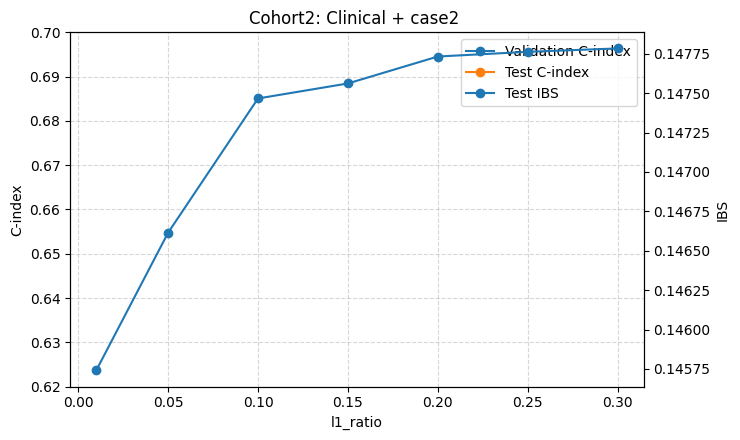

In [216]:
results_df_integrate2cli, best_overall, fig, axes,final_model_2cli=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_2cli_imp,
    X_test=X_test_integrate_2cli_imp,
    y_train=y_train_integrate_2cli,
    y_test=y_test_integrate_2cli,
    l1_list=[0.01,0.05,0.1,0.15,0.2,0.25,0.3],
    title="Cohort1: Clinical + case2 "
)
print(results_df_integrate2cli)
print(best_overall)

/Users/mac1/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  warnings.warn(
/Users/mac1/PyCharmMiscProject/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but CoxnetSurvivalAnalysis was fitted without feature names
  warnings.warn(


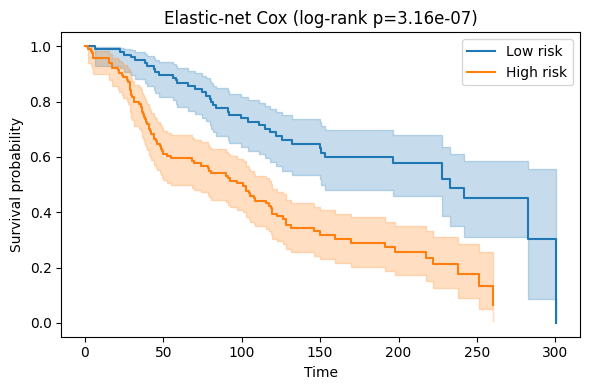

In [218]:
#risk score of optimal model
##Model 4: Elastic Cox with mRNA+methylation (n=1417, mRNA=359, methylation=159) -- data set-up
X_train=X_train_integrate_2cli_imp
X_test=X_test_integrate_2cli_imp
y_train=y_train_integrate_2cli
y_test=y_test_integrate_2cli
#Convert OS_STATUS → numeric event indicator
y_train["OS_STATUS_NUM"] = (
    y_train["OS_STATUS"]
    .str.split(":", expand=True)[0]
    .astype(int)
)
y_test["OS_STATUS_NUM"] = (
    y_test["OS_STATUS"]
    .str.split(":", expand=True)[0]
    .astype(int)
)

cont_cols = list(range(4, 9))           # 5–9 continuous clinical
cat_cols  = list(range(9, 27))          # 10–27 binary/multilevel clinical
gen_cols  = list(range(27, X_train.shape[1]))  # 28+ genetic

Xtr_cont = X_train.iloc[:, cont_cols].copy()
Xte_cont = X_test.iloc[:,  cont_cols].copy()
#one-hot
Xtr_cat = pd.get_dummies(X_train.iloc[:, cat_cols],drop_first=True)
Xte_cat = pd.get_dummies(X_test.iloc[:, cat_cols],drop_first=True)
Xte_cat = Xte_cat.reindex(columns=Xtr_cat.columns, fill_value=0) #align columns after one-hot encoding
Xtr_gen = X_train.iloc[:, gen_cols].copy()
Xte_gen = X_test.iloc[:,  gen_cols].copy()

#Combine
Xtr_full = pd.concat([Xtr_cont, Xtr_cat, Xtr_gen], axis=1) #1133 x 566
Xte_full = pd.concat([Xte_cont, Xte_cat, Xte_gen], axis=1) #284 x 566

#Build survival objects (scikit-survival format)
ytr = np.array(
    [(bool(e), t) for e, t in zip(
        y_train["OS_STATUS_NUM"].values,
        y_train["OS_MONTHS"].values
    )],
    dtype=[("event", "?"), ("time", "<f8")]) #1133 x 2

yte = np.array(
    [(bool(e), t) for e, t in zip(
        y_test["OS_STATUS_NUM"].values,
        y_test["OS_MONTHS"].values
    )],
    dtype=[("event", "?"), ("time", "<f8")]) #284 x 2

#validation set
idx = np.arange(X_train.shape[0])
idx_tr, idx_val = train_test_split(idx, test_size=0.2, random_state=123) #1267+317
ytr_in  = ytr[idx_tr]
ytr_val = ytr[idx_val]

#create risk score based on training data
risk_train = final_model_2cli.predict(Xtr_full)
risk_test  = final_model_2cli.predict(Xte_full)
threshold = np.median(risk_train)
risk_group_test = (risk_test > threshold).astype(int)


from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()

T = yte["time"]
E = yte["event"]

fig, ax_left = plt.subplots(figsize=(6,4))

for grp, label in zip([0,1], ["Low risk", "High risk"]):
    ix = risk_group_test == grp
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot_survival_function(ax=ax)

# log-rank
res = logrank_test(
    T[risk_group_test==0], T[risk_group_test==1],
    E[risk_group_test==0], E[risk_group_test==1]
)

ax_left.set_title(f"Elastic-net Cox (log-rank p={res.p_value:.3g})")
ax_left.set_xlabel("Time")
ax_left.set_ylabel("Survival probability")

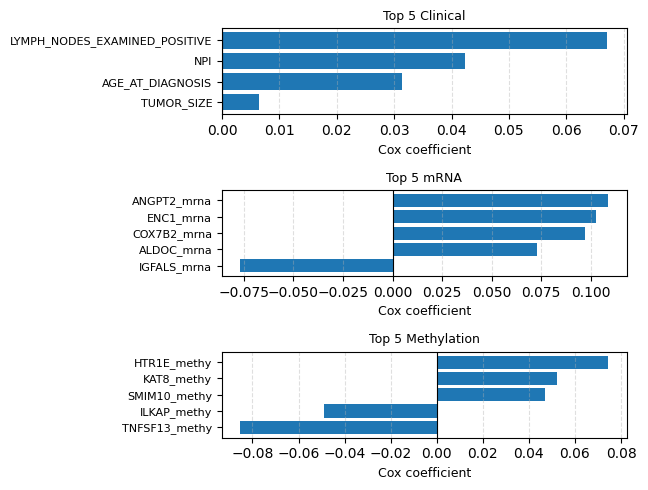

In [224]:
##select top features
coef = pd.Series(
    final_model_2cli.coef_.ravel(),
    index=Xtr_full.columns,
    name="coef"
)

coef_df = coef.to_frame()
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df["selected"] = coef_df["abs_coef"] > 1e-8

coef_df["category"] = "Clinical"
coef_df.loc[coef_df.index.str.endswith("_mrna"), "category"] = "mRNA"
coef_df.loc[coef_df.index.str.endswith("_methy"), "category"] = "Methylation"

summary = (
    coef_df[coef_df["selected"]]
    .groupby("category")
    .agg(
        n_selected=("coef", "size"),
        mean_abs_coef=("abs_coef", "mean")
    )
)

# only selected features
sel = coef_df[coef_df["selected"]]

# summary counts
summary = sel.groupby("category").size()

# top 5 per category
top5_dict = {}
for cat in ["Clinical", "mRNA", "Methylation"]:
    top5 = (
        sel[sel["category"] == cat]
        .sort_values("abs_coef", ascending=False)
        .head(5)
        .sort_values("coef")   # nicer horizontal bars
    )
    top5_dict[cat] = top5


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(
    nrows=3, ncols=2,
    width_ratios=[1.3, 1],
    height_ratios=[1, 1, 1]
)

# ---------- LEFT: big category bar ----------



# ---------- RIGHT: top 5 per category ----------
categories = ["Clinical", "mRNA", "Methylation"]

for i, cat in enumerate(["Clinical", "mRNA", "Methylation"]):
    ax = fig.add_subplot(gs[i, 1])
    top5 = top5_dict[cat]

    if not top5.empty:
        ax.barh(top5.index, top5["coef"])
        ax.axvline(0, color="black", linewidth=0.8)

    ax.set_title(f"Top 5 {cat}", fontsize=9)
    ax.set_xlabel("Cox coefficient",fontsize=9)
    ax.tick_params(axis="y", labelsize=8)
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()



   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.676285     0.647614  0.160799    0.315882         246
1      0.10    0.674143     0.644771  0.161597    0.173340         221
2      0.15    0.673501     0.641989  0.162816    0.115560         212
3      0.20    0.672698     0.640416  0.163719    0.086670         208
4      0.25    0.673822     0.641081  0.162950    0.076096         188
{'val_cindex': 0.6762847965738759, 'l1_ratio': 0.05, 'alpha': 0.31588172118140967, 'model': CoxnetSurvivalAnalysis(alphas=[0.31588172118140967], fit_baseline_model=True,
                       l1_ratio=0.05)}


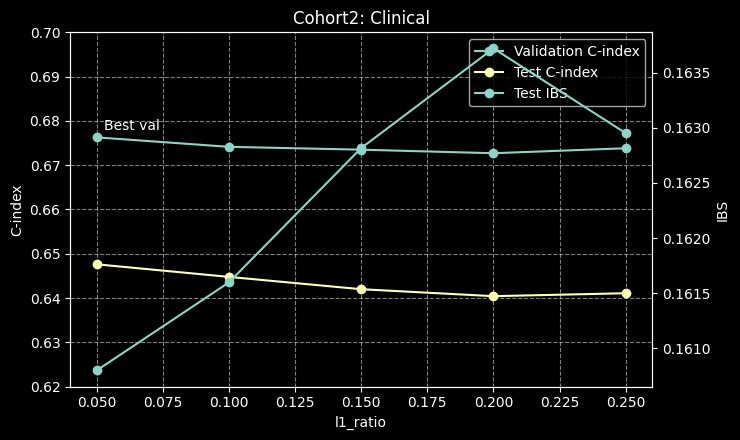

In [123]:
results_df_integrate2_gen, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_2_imp,
    X_test=X_test_integrate_2_imp,
    y_train=y_train_integrate_2,
    y_test=y_test_integrate_2,
    feature_set='gen',
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort1: case2+gwas"
)
print(results_df_integrate2_gen)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.658726     0.649066  0.162686    0.314268         120
1      0.10    0.660064     0.657352  0.162450    0.301369          50
2      0.15    0.661188     0.655537  0.163111    0.220501          43
3      0.20    0.662152     0.651666  0.163392    0.137298          55
4      0.25    0.662741     0.651545  0.163671    0.109838          55
{'val_cindex': 0.6627408993576017, 'l1_ratio': 0.25, 'alpha': 0.10983832059974769, 'model': CoxnetSurvivalAnalysis(alphas=[0.10983832059974769], fit_baseline_model=True,
                       l1_ratio=0.25)}


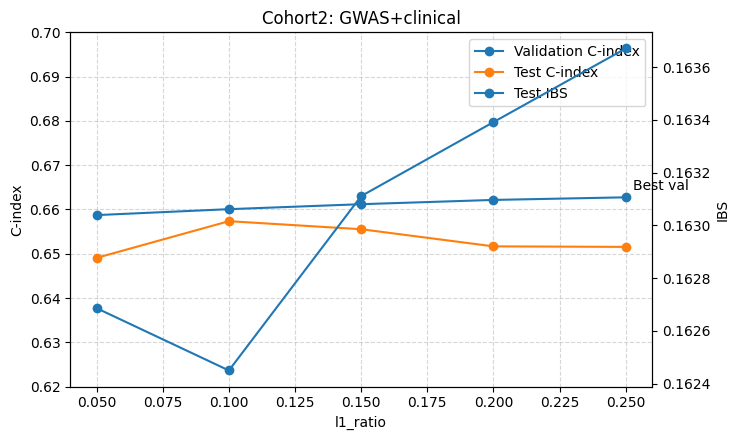

In [164]:
results_df_integrate_gwas, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_integrate_gwas_imp,
    X_test=X_test_integrate_gwas_imp,
    y_train=y_train_integrate_gwas,
    y_test=y_test_integrate_gwas,
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort1: clinical+GWAS"
)
print(results_df_integrate_gwas)
print(best_overall)

   l1_ratio  val_cindex  test_cindex  test_ibs  best_alpha  n_selected
0      0.05    0.670927     0.672649  0.155952    0.338436          62
1      0.10    0.671198     0.668913  0.156224    0.223696          46
2      0.15    0.670977     0.667745  0.156515    0.149131          41
3      0.20    0.671345     0.667178  0.156732    0.111848          41
4      0.25    0.671296     0.666945  0.155237    0.129818          27
{'val_cindex': 0.671345345492982, 'l1_ratio': 0.2, 'alpha': 0.11184812144600899, 'model': CoxnetSurvivalAnalysis(alphas=[0.11184812144600899], fit_baseline_model=True,
                       l1_ratio=0.2)}


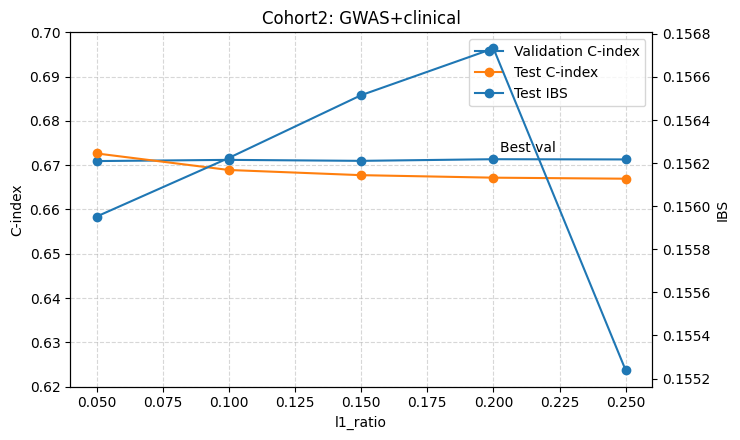

In [156]:
results_df_overall_gwas, best_overall, fig, axes,final_model=elasticnet_cox_sweep_l1_plot(
    X_train=X_train_overall_gwas_imp,
    X_test=X_test_overall_gwas_imp,
    y_train=y_train_overall_gwas,
    y_test=y_test_overall_gwas,
    l1_list=[0.05,0.1,0.15,0.2,0.25],
    title="Cohort2: clinical+GWAS"
)
print(results_df_overall_gwas)
print(best_overall)

In [165]:
##compare performance for difference l1_ratio across context
def plot_context_comparisons(
    df_dict: dict,
    x_col: str = "l1_ratio",
    ctx_order: list | None = None,
    add_markers: bool = True,
):
    """
    df_dict: dict like
      {
        "Cohort2: Clinical + mRNA + GWAS": results_df_overall,
        "Cohort2: Clinical only": results_df_overall_cli,
        ...
      }

    Each df must contain columns:
      l1_ratio, test_cindex, test_ibs, n_selected
    """

    # --- combine into one long table (handy for later) ---
    rows = []
    for ctx, df in df_dict.items():
        d = df.copy()
        d["context"] = ctx
        rows.append(d)
    all_df = pd.concat(rows, ignore_index=True)

    # ensure numeric + sorted
    all_df[x_col] = pd.to_numeric(all_df[x_col])
    all_df["test_cindex"] = pd.to_numeric(all_df["test_cindex"])
    all_df["test_ibs"] = pd.to_numeric(all_df["test_ibs"])
    all_df["n_selected"] = pd.to_numeric(all_df["n_selected"])

    # order contexts if provided
    contexts = ctx_order if ctx_order is not None else list(df_dict.keys())

    # plotting helper
    def _plot_metric(metric_col: str, ylabel: str, title: str):
        fig, ax = plt.subplots(figsize=(8, 4.8))
        for ctx in contexts:
            dfc = all_df[all_df["context"] == ctx].sort_values(x_col)
            ax.plot(
                dfc[x_col].values,
                dfc[metric_col].values,
                marker="o" if add_markers else None,
                label=ctx
            )
        ax.set_xlabel("l1 ratio")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        ax.legend(loc="upper right")
        fig.tight_layout()
        return fig, ax

    fig1, ax1 = _plot_metric("test_cindex", "Test C-index", "Test C-index vs l1 ratio (ElasticNet)")
    fig2, ax2 = _plot_metric("test_ibs", "Test IBS", "Test IBS vs l1 ratio (ElasticNet)")
    fig3, ax3 = _plot_metric("n_selected", "Number selected", "number of selected features vs l1 ratio (ElasticNet)")

    return all_df, {"cindex": (fig1, ax1), "ibs": (fig2, ax2), "n_selected": (fig3, ax3)}


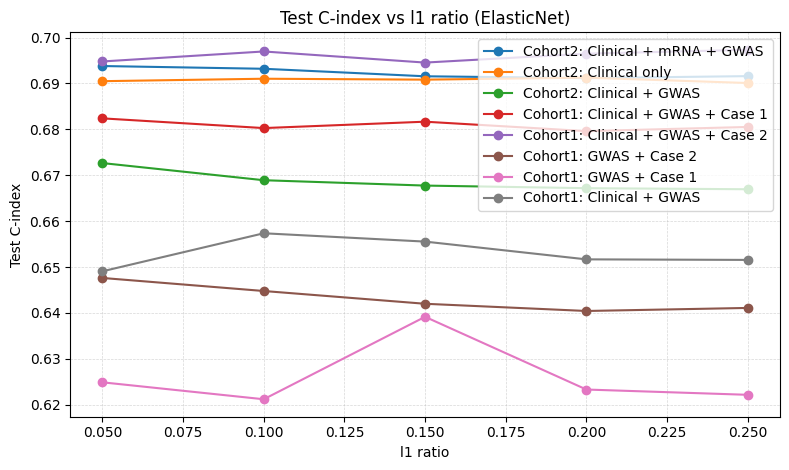

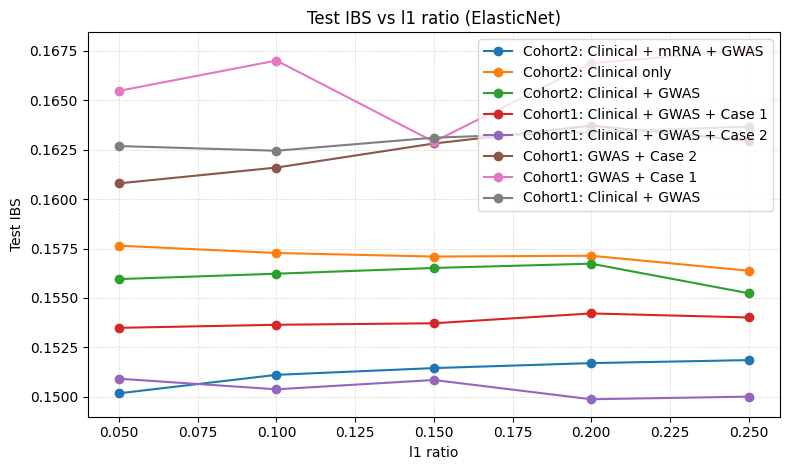

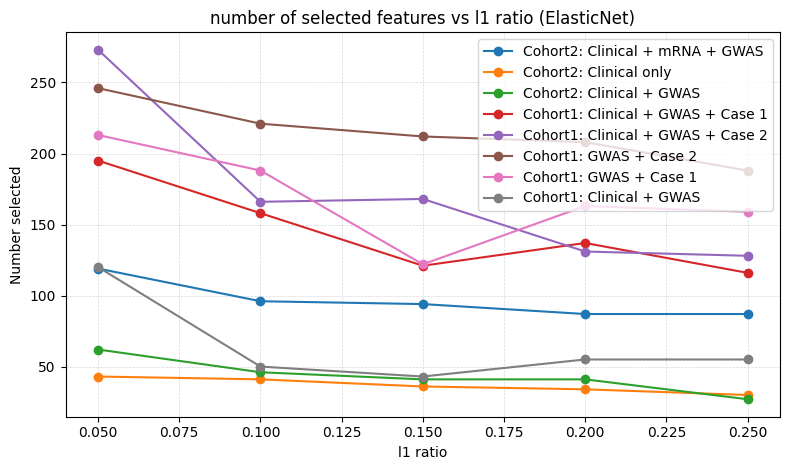

In [166]:
df_dict = {
    "Cohort2: Clinical + mRNA + GWAS": results_df_overall,
    "Cohort2: Clinical only": results_df_overall_cli,
    "Cohort2: Clinical + GWAS": results_df_overall_gwas,
    "Cohort1: Clinical + GWAS + Case 1": results_df_integrate1,
    "Cohort1: Clinical + GWAS + Case 2": results_df_integrate2,
    "Cohort1: GWAS + Case 2": results_df_integrate2_gen,
    "Cohort1: GWAS + Case 1": results_df_integrate1_gen,
    "Cohort1: Clinical + GWAS": results_df_integrate_gwas,
}

all_df, figs = plot_context_comparisons(df_dict)
plt.show()